Mask out:
- Dwarf galaxies
- Globular clusters
- NGC galaxies
- Sagittarius

Do BASS/Decals separately

In [1]:
import os
import sys
_path = os.path.abspath('../')
if _path not in sys.path:
    sys.path.append(_path)

import astropy.coordinates as coord
import astropy.table as at
from astropy.io import fits
import astropy.units as u
import gala.coordinates as gc
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import healpy as hp
from tqdm.notebook import tqdm
from scipy.optimize import leastsq

from stream_helpers import get_data, rots

In [2]:
bass_cube, distmods, bass_footprint = get_data(
    bass_file='../data/BASS_iso_hpxcube_z0.0001_a13.5_gmax23.fits.gz')

decals_cube, distmods, decals_footprint = get_data(
    decals_file='../data/DECaLS_iso_hpxcube_z0.0001_a13.5_gmax23.fits.gz')

npix, nslice = bass_cube.shape
nside = hp.npix2nside(npix)

In [3]:
cubes = {'bass': bass_cube, 'decals': decals_cube}
footprints = {'bass': bass_footprint, 'decals': decals_footprint}

### Masking known objects:

In [4]:
all_blobs = at.Table.read('/Users/apricewhelan/data/Misc/MW_dwarfs_globs.fits')
all_blobs = all_blobs[all_blobs['DM'] < 25]
all_blobs_c = coord.SkyCoord(all_blobs['ra']*u.deg,
                             all_blobs['dec']*u.deg,
                             coord.Distance(distmod=all_blobs['DM']))

# Special case some half-light radii:
all_blobs['r_h'][all_blobs['name'] == 'SagittariusdSph'] = 2.5 * 60
all_blobs['r_h'][all_blobs['name'] == '#Andromeda'] = 1.5 * 60
all_blobs['r_h'][all_blobs['name'] == 'BootesIII'] = 10
all_blobs['r_h'][all_blobs['name'] == 'LMC'] = 5*60
all_blobs['r_h'][all_blobs['name'] == 'SMC'] = 2.5*60
all_blobs['r_h'][all_blobs['name'] == 'Triangulum'] = 60
all_blobs['r_h'][all_blobs['name'] == 'NGC5904 (M 5)'] /= 2

blobs = at.Table.read('/Users/apricewhelan/data/Misc/Vasiliev-globclust.txt',
                      format='ascii.basic')
blobs.rename_column('Name', 'name')
blobs_c = coord.SkyCoord(blobs['RA']*u.deg,
                         blobs['DEC']*u.deg,
                         blobs['D']*u.kpc)

In [5]:
blobs_footprint_idx = {}
for k in footprints.keys():
    in_footprint_idx = []
    for i, cl_c in enumerate(blobs_c):
        pix = hp.ang2pix(nside, cl_c.ra.degree, cl_c.dec.degree, 
                         lonlat=True)

        if footprints[k][pix]:
            in_footprint_idx.append(True)
        else:
            in_footprint_idx.append(False)

    blobs_footprint_idx[k] = np.array(in_footprint_idx)
    print(blobs_footprint_idx[k].sum())

3
22


Make a mask for bright galaxies and globular clusters:

In [6]:
rotator = hp.Rotator(rot=rots['gal'])

Sigma is 12.000000 arcmin (0.003491 rad) 
-> fwhm is 28.257841 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 12.000000 arcmin (0.003491 rad) 
-> fwhm is 28.257841 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


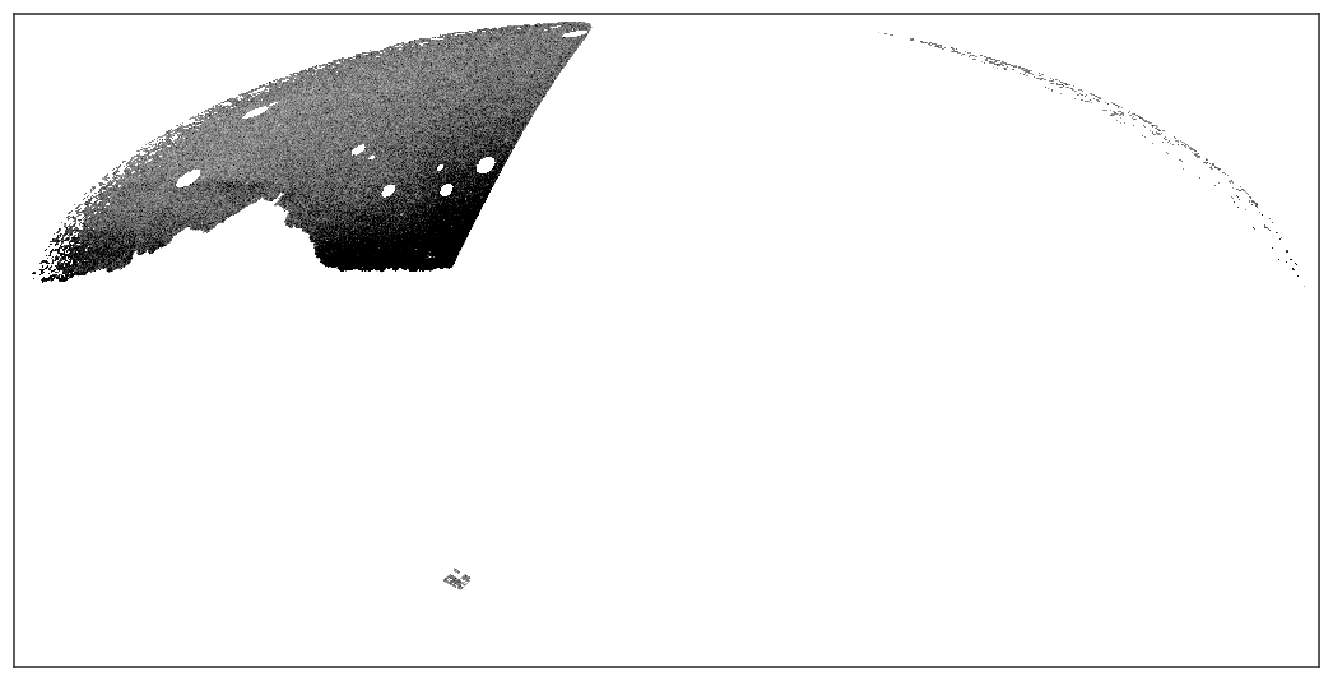

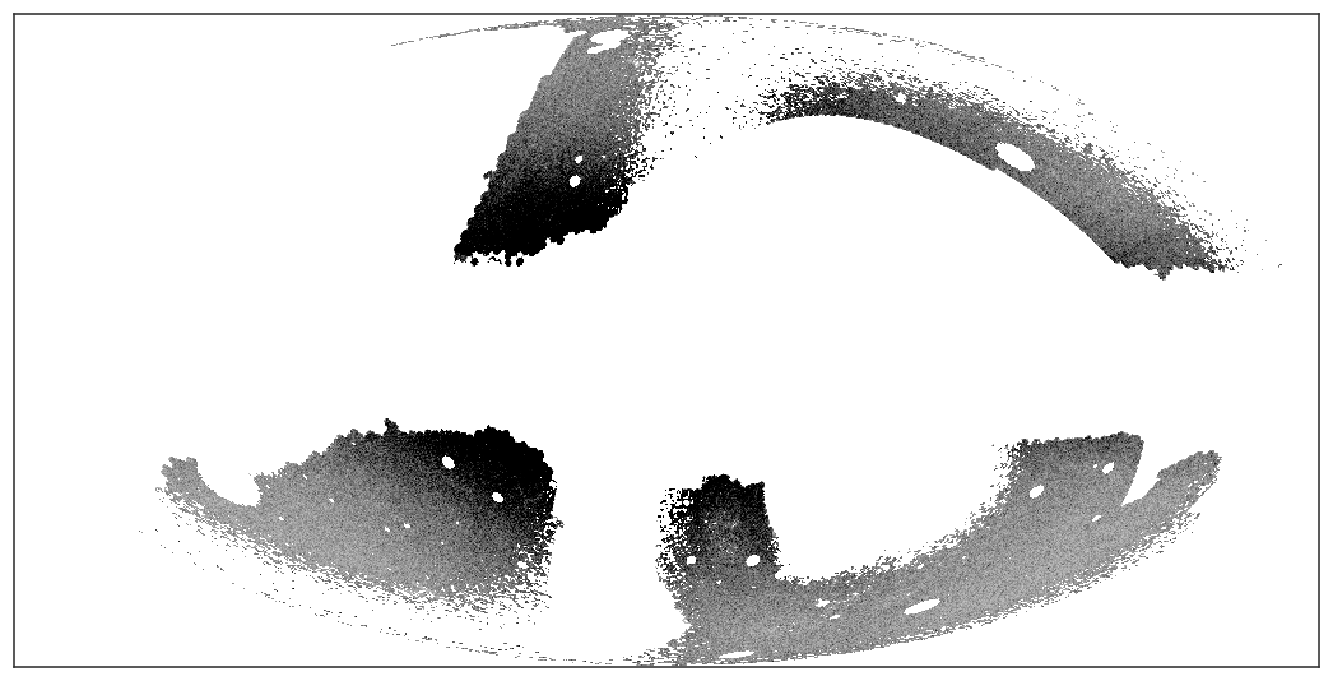

In [7]:
masked_cubes = {}
for k, cube in cubes.items():
    this_blob_mask = np.ones(hp.nside2npix(nside))
    for row, cc in zip(all_blobs, all_blobs_c):        
        size = (cc.distance * row['r_h']*u.arcmin).to_value(u.kpc, u.dimensionless_angles())
        rep = coord.CartesianRepresentation(np.random.normal(cc.cartesian.xyz.to_value(u.kpc), 
                                                             2 * size, 
                                                             (65536, 3)).T * u.kpc)
        spray = coord.SkyCoord(rep)
        this_blob_mask[hp.ang2pix(nside, spray.ra.degree, spray.dec.degree, lonlat=True)] = 0.

    # Also mask out Sag stream:
    mask_c = gc.Sagittarius(np.random.uniform(0, 360, 4*65536)*u.deg,
                            np.random.normal(0, 10, 4*65536)*u.deg).transform_to(coord.ICRS)
    this_blob_mask[hp.ang2pix(nside, mask_c.ra.degree, mask_c.dec.degree, lonlat=True)] = 0.
    
    this_blob_mask = hp.smoothing(this_blob_mask, sigma=np.radians(0.2))
    _derp = this_blob_mask > 0.85
    this_blob_mask[_derp] = 1
    this_blob_mask[~_derp] = 0
    blob_mask = np.array(1 - this_blob_mask, dtype=bool)
    
    # stacked and masked maps:
    stacked_and_masked = np.sum(cube[:, 5:40], axis=1) / 35
    stacked_and_masked[blob_mask] = hp.UNSEEN
    stacked_and_masked[~footprints[k]] = hp.UNSEEN
    
    proj = hp.projector.MollweideProj(xsize=1024, rot=rots['gal'])
    func = lambda x, y, z: hp.vec2pix(nside, x, y, z)
    img = proj.projmap(stacked_and_masked, func)

    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.imshow(img, origin='bottom', extent=proj.get_extent(), 
              vmin=-5, vmax=1e1, cmap='Greys')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
    # Mask out regions
    masked_cubes[k] = cubes[k].copy()
    masked_cubes[k][blob_mask] = hp.UNSEEN
    masked_cubes[k][~footprints[k]] = hp.UNSEEN

In [34]:
masked_cubes_gal = {}
for k, cube in masked_cubes.items():
    masked_cubes_gal[k] = np.stack([rotator.rotate_map_pixel(cube[:, j]) 
                                    for j in range(nslice)], axis=1)

In [ ]:
cube = masked_cubes_gal['bass']

In [ ]:
lmax = 4
alm = hp.map2alm(cube[:, 0], lmax=lmax, mmax=0)
bg = hp.alm2map(alm, nside=nside, lmax=lmax)

Construct a low-order reconstruction using spherical harmonics:

In [ ]:
lmax = 4
alm = hp.map2alm(full_stack_masked, lmax=lmax, mmax=0)
bg = hp.alm2map(alm, nside=nside, lmax=lmax)

In [353]:


img = proj.projmap(bg, func)
fig, ax = plt.subplots(1, 1, figsize=(16, 16))
ax.imshow(img, origin='bottom', extent=proj.get_extent())
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

img = proj.projmap(full_stack - bg, func)
fig, ax = plt.subplots(1, 1, figsize=(16, 16))
ax.imshow(img, origin='bottom', extent=proj.get_extent(), vmin=0, vmax=1e4)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

In [447]:
def bg_func(l, b, coeff_l, coeff_b):
    l_poly = np.poly1d(coeff_l)
    b_poly = np.poly1d(coeff_b)
    return l_poly(l) * b_poly(b)

def fit_func(p, l, b, val, Kl, Kb):
    return bg_func(l, b, p[:Kl], p[Kl:Kl+Kb]) - val

In [448]:
x0_b = [3.1, 0, -2e-4, 0, 1e-8, 0, 0][::-1]
x0_l = [2.75, 0, -1e-4, 0, 3e-9, 0, 0][::-1]
x0 = np.concatenate((x0_l, x0_b))

_data_mask = (full_stack_masked != 0)
res, ier = leastsq(fit_func, x0=x0, 
                   args=(pix_l[_data_mask].wrap_at(180*u.deg).value, 
                         np.cos(pix_b[_data_mask]), 
                         np.log10(full_stack_masked[_data_mask]),
                         len(x0_l), len(x0_b)))

In [449]:
res, ier = res

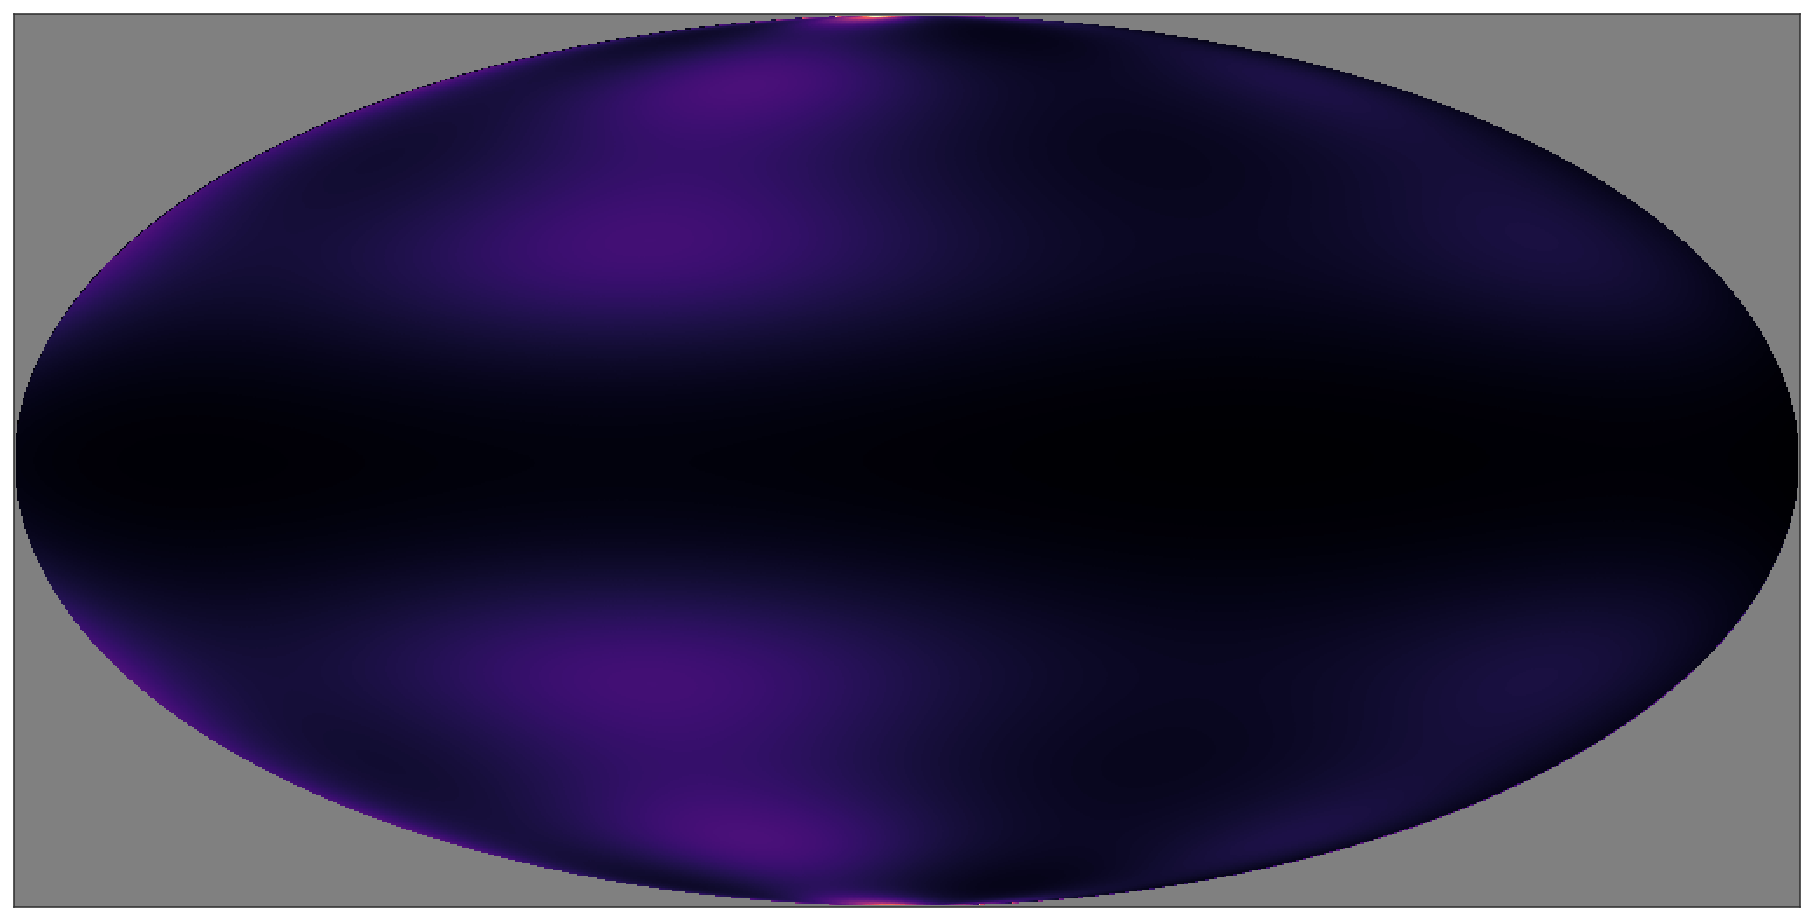

In [450]:
proj = hp.projector.MollweideProj(xsize=1024, 
                                  rot=[266.40498829, -28.93617776, 59.])
bg_model = 10 ** bg_func(pix_l.wrap_at(180*u.deg).value, 
                         np.cos(pix_b), 
                         res[:len(x0_l)], res[len(x0_l):])

img = proj.projmap(bg_model, func)

fig, ax = plt.subplots(1, 1, figsize=(16, 16))
ax.imshow(img, origin='bottom', extent=proj.get_extent())
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

In [350]:
# plt.figure(figsize=(10, 8))
# plt.plot(pix_b[(full_stack_masked != 0)].value, 
#          np.log10(full_stack_masked[(full_stack_masked != 0)]),
#          marker='o', mew=0, ls='none', ms=1.5, alpha=0.1)

# bbb = np.linspace(-90, 90, 128)
# plt.plot(bbb, np.poly1d(x0_b)(bbb))

# plt.figure(figsize=(10, 8))
# plt.plot(pix_l[(full_stack_masked != 0)].wrap_at(180*u.deg).value, 
#          np.log10(full_stack_masked[(full_stack_masked != 0)]),
#          marker='o', mew=0, ls='none', ms=1.5, alpha=0.1)

# bbb = np.linspace(-180, 180, 128)
# plt.plot(bbb, np.poly1d(x0_l)(bbb))

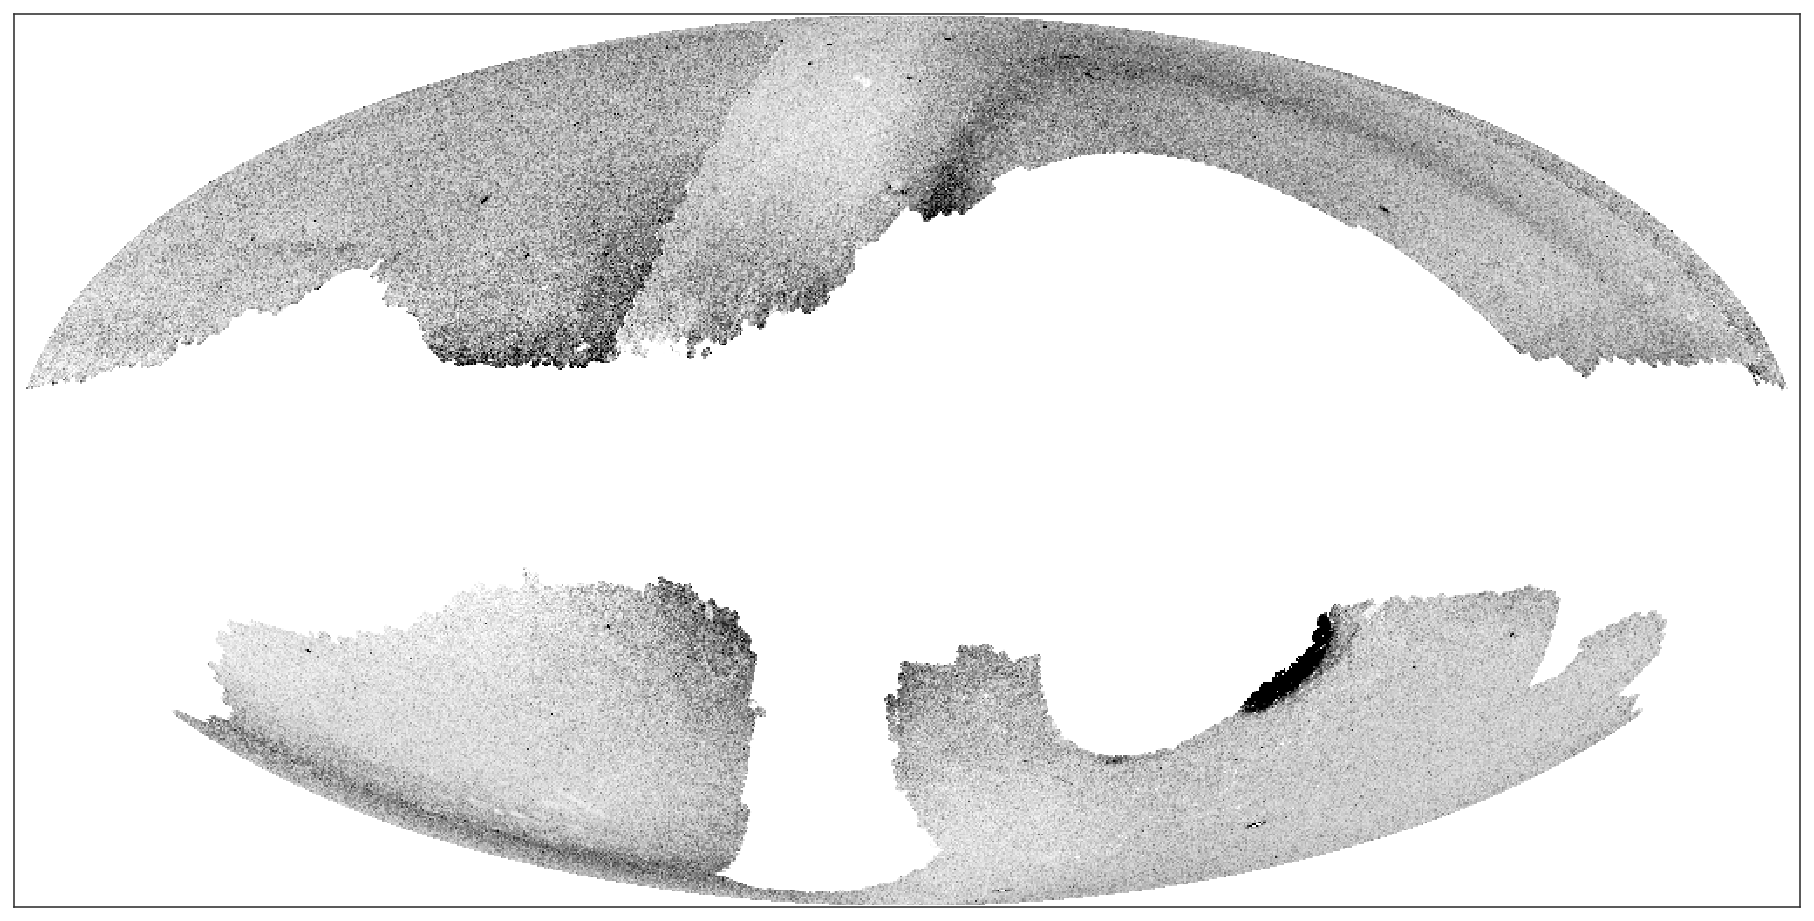

In [352]:
proj = hp.projector.MollweideProj(xsize=1024, 
                                  rot=[266.40498829, -28.93617776, 59.])
bg_model = 10 ** bg_func(pix_l.wrap_at(180*u.deg).value, np.cos(pix_b), #.value, 
                         res[0][:len(x0_l)], res[0][len(x0_l):])
# img = proj.projmap(bg_model, func)

diff = full_stack - bg_model
diff[full_stack == 0] = hp.UNSEEN
img = proj.projmap(diff, func)

fig, ax = plt.subplots(1, 1, figsize=(16, 16))
ax.imshow(img, origin='bottom', extent=proj.get_extent(), 
          vmin=-5, vmax=1e1, cmap='Greys')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

Construct a low-order reconstruction using spherical harmonics:

In [353]:
# meh, doesn't work!
# lmax = 4
# alm = hp.map2alm(full_stack_masked, lmax=lmax)
# bg = hp.alm2map(alm, nside=nside, lmax=lmax)

# img = proj.projmap(bg, func)
# fig, ax = plt.subplots(1, 1, figsize=(16, 16))
# ax.imshow(img, origin='bottom', extent=proj.get_extent())
# ax.xaxis.set_visible(False)
# ax.yaxis.set_visible(False)

# img = proj.projmap(full_stack - bg, func)
# fig, ax = plt.subplots(1, 1, figsize=(16, 16))
# ax.imshow(img, origin='bottom', extent=proj.get_extent(), vmin=0, vmax=1e4)
# ax.xaxis.set_visible(False)
# ax.yaxis.set_visible(False)